In [2]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from matplotlib.widgets import Slider
import matplotlib.patheffects as path_effects
import os
import stdatamodels.jwst.datamodels as dm
from astropy.io import fits
from glob import glob
import pandas as pd

In [ ]:
class DataCube:
	"""
	An object combining multiple 1D and 2D spectra from a given folder.
	
	
	Parameters :
	----------
	folder :
		path to the folder containing the final data. Will loop on every fits file 
		and keep the one containing the _s2d or _x1d suffix
	
	Properties : 
	----------
	table : 
		a table used for making a correspondence between a source id, a s2d file and a x1d file. 
		Those files are stored as a list of paths 
	"""
	
	def __init__(self, folder):

		#s2dList = [[file] for file in sorted(glob(os.path.join(folder, '*_s2d.fits'))) if (len(fits.open(file)[1].header.get("SHUTSTA", "")) == 3)]
		#x1dList = [[[x] if os.path.exists(x := file[0].replace("_s2d", "_x1d")) else [None]] for file in s2dList]
		s2dList = [[file] for file in sorted(glob(os.path.join(folder, '*_s2d.fits')))]
		x1dList = [[x] if os.path.exists(x := file[0].replace("_s2d", "_x1d")) else [None] for file in s2dList]
		sourceList = [fits.open(file[0])[1].header["SOURCEID"] for file in s2dList]
		
		self.table = pd.DataFrame({"sourceID": sourceList, "s2d": s2dList, "x1d": x1dList})

		# Initializes the dataframe which will contain the data models
		self.dataTable = pd.DataFrame({"sourceID" : [], "s2d" : [], "x1d" : []})

		
		
	def combineDataCube(self, datacube, i=1):
		"""
		Combines 2 Datacubes
		Parameters
		----------
		datacube :
			Another datacube to be appended to this one
		"""
		
		print("Starting Combining Datacubes")
		
		print("Merging...")
		# Perform an outer join to include all sourceIDs from both DataFrames
		merged = self.table.merge(
			datacube.table, on="sourceID", how="outer", suffixes=("_self", "_other")
		)
		
		print("Replacing empty values...")
		# Fill missing values in 's2d' and 'x1d' columns with empty lists
		merged["s2d_self"] = merged["s2d_self"].apply(lambda x: x if isinstance(x, list) else [None for j in range(i)])
		merged["s2d_other"] = merged["s2d_other"].apply(lambda x: x if isinstance(x, list) else [None])
		merged["x1d_self"] = merged["x1d_self"].apply(lambda x: x if isinstance(x, list) else [None for j in range(i)])
		merged["x1d_other"] = merged["x1d_other"].apply(lambda x: x if isinstance(x, list) else [None])
		
		print("Appending paths...")
		# Combine the 's2d' and 'x1d' columns
		merged["s2d"] = merged["s2d_self"] + merged["s2d_other"]
		merged["x1d"] = merged["x1d_self"] + merged["x1d_other"]
		
		# Keep only necessary columns: 'sourceID', 's2d', 'x1d'
		self.table = merged[["sourceID", "s2d", "x1d"]]
		
		print("Finished Combining Datacubes!")

	def preloadDataCube(self):
		"""
		Initializes self.dataTable, a table structurally identical to self.table, 
		except the paths are replaced by the corresponding datamodels
		"""
		print("Starting loading data...")
		print("Copying...")
		self.dataTable = self.table.copy()
		
		# Process lists of file paths
		def processList(fileList):
			print(fileList)
			return [dm.open(file) if isinstance(file, str) else None for file in fileList]
		
		print("Loading...")
		# Process the 'x1d' and 's2d' columns
		self.dataTable["x1d"] = self.dataTable["x1d"].apply(processList)
		self.dataTable["s2d"] = self.dataTable["s2d"].apply(processList)
		
		print("Finished loading data!")
		
	def exploreDataCube(self):
		print("Exploring Data")
		fig, axes = plt.subplots(4, 1, figsize=(18, 7), gridspec_kw={'height_ratios': [1, 1, 1, 5]})
		plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, hspace=0)
		print("Made Figure")
		
		idx = 0

		if not self.dataTable["s2d"][idx][0] is None:
			z1, z2 = ZScaleInterval().get_limits(self.dataTable["s2d"][idx][0].data)
		elif not self.dataTable["s2d"][idx][1] is None:
			z1, z2 = ZScaleInterval().get_limits(self.dataTable["s2d"][idx][1].data)
		else:
			z1, z2 = ZScaleInterval().get_limits(self.dataTable["s2d"][idx][2].data)
		
		def drawExtraction(axe, x1d):
			x0 = x1d.extraction_xstart
			x1 = x1d.extraction_xstop
			y0 = x1d.extraction_ystart
			y1 = x1d.extraction_ystop
			axe.vlines((x0, x1), (y0, y0), (y1, y1), color='r', linestyles='dashed', linewidth=0.5)
			axe.hlines((y0, y1), (x0, x0), (x1, x1), color='r', linestyles='dashed', linewidth=0.5)
	
		# Display initial images
		if not self.dataTable["s2d"][idx][0] is None:
			axes[0].imshow(self.dataTable["s2d"][idx][0].data, aspect='auto', vmin=z1, vmax=z2, cmap="viridis", origin="lower")
			drawExtraction(axes[0], self.dataTable["x1d"][idx][0].spec[0])
			print("Data for Custom Pipeline")
		if not self.dataTable["s2d"][idx][1] is None:
			axes[1].imshow(self.dataTable["s2d"][idx][1].data, aspect='auto', vmin=z1, vmax=z2, cmap="viridis", origin="lower")
			drawExtraction(axes[1], self.dataTable["x1d"][idx][1].spec[0])
			print("Data for Basic Pipeline")
		if not self.dataTable["s2d"][idx][2] is None:
			axes[2].imshow(self.dataTable["s2d"][idx][2].data, aspect='auto', vmin=z1, vmax=z2, cmap="viridis", origin="lower")
			drawExtraction(axes[2], self.dataTable["x1d"][idx][2].spec[0])
			print("Data for No Subtraction")
		
		text = axes[0].text(0.02, 0.3, "Custom Pipeline", color="w", transform=axes[0].transAxes)
		text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
		text = axes[1].text(0.02, 0.3, "Basic Pipeline", color="w", transform=axes[1].transAxes)
		text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
		text = axes[2].text(0.02, 0.3, "No Subtraction", color="w", transform=axes[2].transAxes)
		text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
		
		axes[0].set_axis_off()
		axes[1].set_axis_off()
		axes[2].set_axis_off()
		
		if not self.dataTable["x1d"][idx][0] is None:
			wavelength = self.dataTable["x1d"][idx][0].spec[0].spec_table["WAVELENGTH"]
			flux = self.dataTable["x1d"][idx][0].spec[0].spec_table["FLUX"]
			err = self.dataTable["x1d"][idx][0].spec[0].spec_table["FLUX_ERROR"]
			axes[3].errorbar(wavelength, flux, yerr=err, label='Custom Pipeline', capsize=3)
			print("Data for Custom Pipeline")
		
		if not self.dataTable["x1d"][idx][1] is None:
			wavelength = self.dataTable["x1d"][idx][1].spec[0].spec_table["WAVELENGTH"]
			flux = self.dataTable["x1d"][idx][1].spec[0].spec_table["FLUX"]
			err = self.dataTable["x1d"][idx][1].spec[0].spec_table["FLUX_ERROR"]
			axes[3].errorbar(wavelength, flux, yerr=err, label='Basic Pipeline', capsize=3)
			print("Data for Basic Pipeline")
		
		if not self.dataTable["x1d"][idx][2] is None:
			wavelength = self.dataTable["x1d"][idx][2].spec[0].spec_table["WAVELENGTH"]
			flux = self.dataTable["x1d"][idx][2].spec[0].spec_table["FLUX"]
			err = self.dataTable["x1d"][idx][2].spec[0].spec_table["FLUX_ERROR"]
			axes[3].errorbar(wavelength, flux, yerr=err, label='No Subtraction', capsize=3)
			print("Data for No Subtraction")
		
		axes[3].text(0.05, 0.05, f"SourceID: {self.dataTable['sourceID'][idx]}", color="k", transform=axes[3].transAxes, size=15)
		axes[3].grid()
		axes[3].legend()
		
		
		# Update sourceID
		def update(val):
			idx = int(slider.val)  # Get the current slider value
			
			if not self.dataTable["s2d"][idx][0] is None:
				z1, z2 = ZScaleInterval().get_limits(self.dataTable["s2d"][idx][0].data)
			elif not self.dataTable["s2d"][idx][1] is None:
				z1, z2 = ZScaleInterval().get_limits(self.dataTable["s2d"][idx][1].data)
			else:
				z1, z2 = ZScaleInterval().get_limits(self.dataTable["s2d"][idx][2].data)
			
			axes[0].clear()
			if not self.dataTable["s2d"][idx][0] is None:
				axes[0].imshow(self.dataTable["s2d"][idx][0].data, aspect='auto', vmin=z1, vmax=z2, cmap="viridis", origin="lower")
				drawExtraction(axes[0], self.dataTable["x1d"][idx][0].spec[0])
			axes[1].clear()
			if not self.dataTable["s2d"][idx][1] is None:
				axes[1].imshow(self.dataTable["s2d"][idx][1].data, aspect='auto', vmin=z1, vmax=z2, cmap="viridis", origin="lower")
				drawExtraction(axes[1], self.dataTable["x1d"][idx][1].spec[0])
			axes[2].clear()
			if not self.dataTable["s2d"][idx][2] is None:
				axes[2].imshow(self.dataTable["s2d"][idx][2].data, aspect='auto', vmin=z1, vmax=z2, cmap="viridis", origin="lower")
				drawExtraction(axes[2], self.dataTable["x1d"][idx][2].spec[0])
			
			text = axes[0].text(0.02, 0.3, "Custom Pipeline", color="w", transform=axes[0].transAxes)
			text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
			text = axes[1].text(0.02, 0.3, "Basic Pipeline", color="w", transform=axes[1].transAxes)
			text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
			text = axes[2].text(0.02, 0.3, "No Subtraction", color="w", transform=axes[2].transAxes)
			text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
				
			axes[3].clear()  # Clear the current error bar plot
			
			if not self.dataTable["x1d"][idx][0] is None:
				wavelength = self.dataTable["x1d"][idx][0].spec[0].spec_table["WAVELENGTH"]
				flux = self.dataTable["x1d"][idx][0].spec[0].spec_table["FLUX"] * 1.1
				err = self.dataTable["x1d"][idx][0].spec[0].spec_table["FLUX_ERROR"]
				axes[3].errorbar(wavelength, flux, yerr=err, label='Custom Pipeline', capsize=3)
			
			if not self.dataTable["x1d"][idx][1] is None:
				wavelength = self.dataTable["x1d"][idx][1].spec[0].spec_table["WAVELENGTH"]
				flux = self.dataTable["x1d"][idx][1].spec[0].spec_table["FLUX"] * 0.9
				err = self.dataTable["x1d"][idx][1].spec[0].spec_table["FLUX_ERROR"]
				axes[3].errorbar(wavelength, flux, yerr=err, label='Basic Pipeline', capsize=3)
				
			if not self.dataTable["x1d"][idx][2] is None:
				wavelength = self.dataTable["x1d"][idx][2].spec[0].spec_table["WAVELENGTH"]
				flux = self.dataTable["x1d"][idx][2].spec[0].spec_table["FLUX"]
				err = self.dataTable["x1d"][idx][2].spec[0].spec_table["FLUX_ERROR"]
				axes[3].errorbar(wavelength, flux, yerr=err, label='No Subtraction', capsize=3)
			
			axes[3].text(0.05, 0.05, f"SourceID: {self.dataTable['sourceID'][idx]}", color="k", transform=axes[3].transAxes, size=15)
			axes[3].legend()
			axes[3].grid()
			fig.canvas.draw_idle()
			
			axes[0].set_axis_off()
			axes[1].set_axis_off()
			axes[2].set_axis_off()
		
		# Slider
		ax_slider = plt.axes((0.2, 0.05, 0.6, 0.03))
		N = len(self.dataTable["sourceID"])
		slider = Slider(ax_slider, 'Source', 0, N - 1, valinit=idx, valstep=1)
		print("Slider")
		
		# Attach the update function to the slider
		slider.on_changed(update)
		
		def onKey(event):
			current = slider.val
			if event.key == "right":  # Move slider one step right
				new = min(current + 1, N - 1)  # Ensure within bounds
				slider.set_val(new)
			elif event.key == "left":  # Move slider one step left
				new = max(current - 1, 0)  # Ensure within bounds
				slider.set_val(new)

		# Connect keypress handler
		fig.canvas.mpl_connect("key_press_event", onKey)
		
		# Show the plot
		plt.show()


In [ ]:
dc = DataCube("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/Final")
dc.combineDataCube(DataCube("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/Default/Final"))
dc.combineDataCube(DataCube("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/NoSubtraction/Final"), i=2)

dc.table

In [ ]:
dc.preloadDataCube()
dc.dataTable

In [ ]:
%matplotlib tkagg
dc.exploreDataCube()

In [10]:
path = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/TestCustom/jw01345063001_03101_00003_nrs2_photomstep.fits"

custom = dm.open(path)

path = "/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/TestDefault/jw01345063001_03101_00003_nrs2_photom.fits"

default = dm.open(path)


20406
134


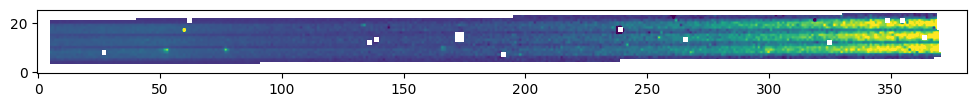

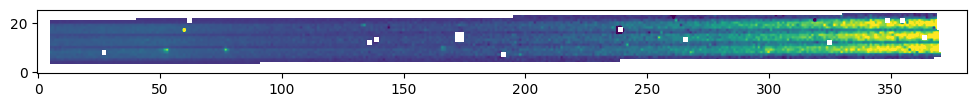

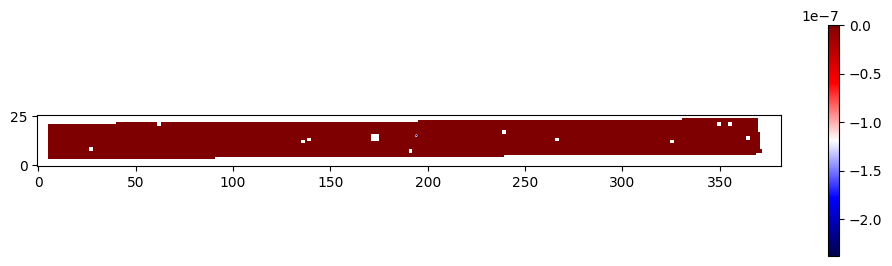

In [14]:
%matplotlib inline

for i,slit in enumerate(custom.slits) :
	if slit.name == "134":
		print(slit.source_id)
		print(slit.name)
		z1, z2 = ZScaleInterval(contrast=0.2).get_limits(slit.data)
		plt.figure(figsize=(12,3))
		plt.imshow(slit.data, origin='lower', vmin=z1, vmax=z2)
		plt.show()

		z1, z2 = ZScaleInterval(contrast=0.2).get_limits(slit.data)
		plt.figure(figsize=(12,3))
		plt.imshow(default.slits[i].data, origin='lower', vmin=z1, vmax=z2)
		plt.show()

		plt.figure(figsize=(12,3))
		plt.imshow((default.slits[i].data - slit.data)/default.slits[i].data, origin='lower', cmap="seismic")
		plt.colorbar()
		plt.show()

In [15]:
default = fits.open("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/Default/Final/jw01345-o063_s000014867_nirspec_clear-prism_s2d.fits")
custom = fits.open("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CEERS-NIRSPEC-P5-PRISM-MSATA/Final/jw01345-o063_s000014867_nirspec_clear-prism_s2d.fits")

In [27]:
header1 = default[0].header
header2 = custom[0].header

# Create a set of all keys in both headers
all_keys = set(header1.keys()).union(set(header2.keys()))

# Iterate through all keys
for key in all_keys:
	value1 = header1.get(key, None)
	value2 = header2.get(key, None)

	# Check if the values are different or one is missing
	if value1 != value2:
		print(f"{key}, {value1}, {value2}")


S_MSBSUB, SKIPPED, None
DATE, 2024-12-12T16:07:50.856, 2024-12-12T11:59:12.712
S_BKDSUB, COMPLETE, None
